In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn.metrics import confusion_matrix, classification_report
import time

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d emmarex/plantdisease
!unzip plantdisease.zip -d plantvillage


Streaming output truncated to the last 5000 lines.
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08c033bd-fbc3-445a-88d1-1863070e52ce___YLCV_GCREC 2872.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08dd176c-e9d9-4746-92c3-fa8dc9074347___UF.GRC_YLCV_Lab 03057.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/08f78a80-46f5-45a6-937c-4d05d61c08c2___UF.GRC_YLCV_Lab 01895.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0903aa95-6e8a-4abd-a003-126fcd9a5493___YLCV_GCREC 2806.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/0911d416-d73d-4c2a-8e45-207a7ceb7c9a___YLCV_GCREC 2773.JPG  
  inflating: plantvillage/plantvillage/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus/09188838-cc89-4925-94c5-d9563c4cb4bf___UF.GRC_YLCV_Lab 02974.JPG  
  inflating: plantvillage

In [12]:
dataset_path = "plantvillage/PlantVillage"
classes = sorted(os.listdir(dataset_path))
print("Classes:", classes)

num_classes = len(classes)
print("Number of classes:", num_classes)


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']
Number of classes: 15


In [13]:
for cls in classes:
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):
        count = len(os.listdir(cls_path))
        print(f"{cls}: {count} images")


Pepper__bell___Bacterial_spot: 997 images
Pepper__bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images
Tomato__Tomato_mosaic_virus: 373 images
Tomato_healthy: 1591 images


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=15):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5_depthwise = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, groups=128)
        self.conv5_pointwise = nn.Conv2d(128, 128, kernel_size=1)
        self.bn5 = nn.BatchNorm2d(128)

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc1 = nn.Linear(128, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))

        x = F.relu(self.bn5(self.conv5_pointwise(self.conv5_depthwise(x))))

        x = self.global_avg_pool(x)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x


model = SimpleCNN(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)



In [15]:
def count_parameters_by_layer(model):
    total_params = 0
    print("Layer-wise parameter count:")

    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            print(f"Layer: {name}, Parameters: {num_params}")
            total_params += num_params

    print(f"Total Trainable Parameters: {total_params}")

count_parameters_by_layer(model)


Layer-wise parameter count:
Layer: conv1.weight, Parameters: 864
Layer: conv1.bias, Parameters: 32
Layer: bn1.weight, Parameters: 32
Layer: bn1.bias, Parameters: 32
Layer: conv2.weight, Parameters: 18432
Layer: conv2.bias, Parameters: 64
Layer: bn2.weight, Parameters: 64
Layer: bn2.bias, Parameters: 64
Layer: conv3.weight, Parameters: 73728
Layer: conv3.bias, Parameters: 128
Layer: bn3.weight, Parameters: 128
Layer: bn3.bias, Parameters: 128
Layer: conv4.weight, Parameters: 147456
Layer: conv4.bias, Parameters: 128
Layer: bn4.weight, Parameters: 128
Layer: bn4.bias, Parameters: 128
Layer: conv5_depthwise.weight, Parameters: 1152
Layer: conv5_depthwise.bias, Parameters: 128
Layer: conv5_pointwise.weight, Parameters: 16384
Layer: conv5_pointwise.bias, Parameters: 128
Layer: bn5.weight, Parameters: 128
Layer: bn5.bias, Parameters: 128
Layer: fc1.weight, Parameters: 65536
Layer: fc1.bias, Parameters: 512
Layer: fc2.weight, Parameters: 7680
Layer: fc2.bias, Parameters: 15
Total Trainable Pa

In [16]:
dataset_path = "plantvillage/PlantVillage"

transform = transforms.Compose([
    transforms.Resize((192, 192)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root = dataset_path, transform = transform)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = torch.utils.data.random_split(train_dataset, [train_size, val_size])


classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)
print("Classes:", classes)


Classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [17]:



def train(model, train_loader, val_loader, criterion, optimizer, num_epochs = 10, print_interval = 100):
    best_accuracy = 0.0
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        total_batches = len(train_loader)

        start_time = time.time()

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (batch_idx + 1) % print_interval == 0 or (batch_idx + 1) == total_batches:
                train_accuracy = (correct_train / total_train) * 100
                print(f"Epoch [{epoch+1}/{num_epochs}], "
                      f"Batch [{batch_idx+1}/{total_batches}], "
                      f"Train Loss: {running_train_loss/(batch_idx+1):.4f}, "
                      f"Train Accuracy: {train_accuracy:.2f}%")

        epoch_train_loss = running_train_loss / total_batches
        train_accuracy = (correct_train / total_train) * 100
        train_losses.append(epoch_train_loss)

        # Validation step
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_accuracy = (correct_val / total_val) * 100
        val_losses.append(epoch_val_loss)

        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
              f"Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}% | "
              f"Time: {epoch_duration:.2f}s")


    torch.save(model.state_dict(), 'best_model.pth')

    return model, train_losses, val_losses



def evaluate(model, val_loader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    report = classification_report(all_labels, all_preds, target_names=classes)
    print("Classification Report:")
    print(report)



In [20]:
model = SimpleCNN(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(train_data, batch_size = 16, shuffle = True)
val_loader = DataLoader(val_data, batch_size = 16, shuffle = False)

num_epochs = 10
print_interval = 100

model, train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, print_interval)

evaluate(model, val_loader)

Epoch [1/10], Batch [100/1032], Train Loss: 2.0385, Train Accuracy: 35.94%
Epoch [1/10], Batch [200/1032], Train Loss: 1.7625, Train Accuracy: 44.06%
Epoch [1/10], Batch [300/1032], Train Loss: 1.6206, Train Accuracy: 48.35%
Epoch [1/10], Batch [400/1032], Train Loss: 1.5200, Train Accuracy: 51.64%
Epoch [1/10], Batch [500/1032], Train Loss: 1.4301, Train Accuracy: 54.37%
Epoch [1/10], Batch [600/1032], Train Loss: 1.3653, Train Accuracy: 56.41%
Epoch [1/10], Batch [700/1032], Train Loss: 1.3180, Train Accuracy: 57.75%
Epoch [1/10], Batch [800/1032], Train Loss: 1.2716, Train Accuracy: 59.09%
Epoch [1/10], Batch [900/1032], Train Loss: 1.2337, Train Accuracy: 60.27%
Epoch [1/10], Batch [1000/1032], Train Loss: 1.1968, Train Accuracy: 61.37%
Epoch [1/10], Batch [1032/1032], Train Loss: 1.1886, Train Accuracy: 61.54%
Epoch [1/10] | Train Loss: 1.1886 | Train Accuracy: 61.54% | Val Loss: 0.6894 | Val Accuracy: 77.57% | Time: 336.61s
Epoch [2/10], Batch [100/1032], Train Loss: 0.8672, Trai

In [21]:

torch.save(model.state_dict(), "simple_cnn.pth")


In [22]:
model = SimpleCNN(num_classes=15)
model.load_state_dict(torch.load("simple_cnn.pth"))
model.to(device)
model.eval()

from sklearn.metrics import classification_report, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

acc = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {acc:.4f}")



Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.99      0.90      0.95       209
                     Pepper__bell___healthy       0.98      0.98      0.98       300
                      Potato___Early_blight       0.97      0.98      0.98       194
                       Potato___Late_blight       0.89      0.98      0.93       186
                           Potato___healthy       1.00      0.77      0.87        26
                      Tomato_Bacterial_spot       0.97      0.95      0.96       422
                        Tomato_Early_blight       0.83      0.87      0.85       203
                         Tomato_Late_blight       0.96      0.86      0.91       410
                           Tomato_Leaf_Mold       0.91      0.97      0.94       186
                  Tomato_Septoria_leaf_spot       0.95      0.94      0.95       356
Tomato_Spider_mites_Two_spotted_spider_m

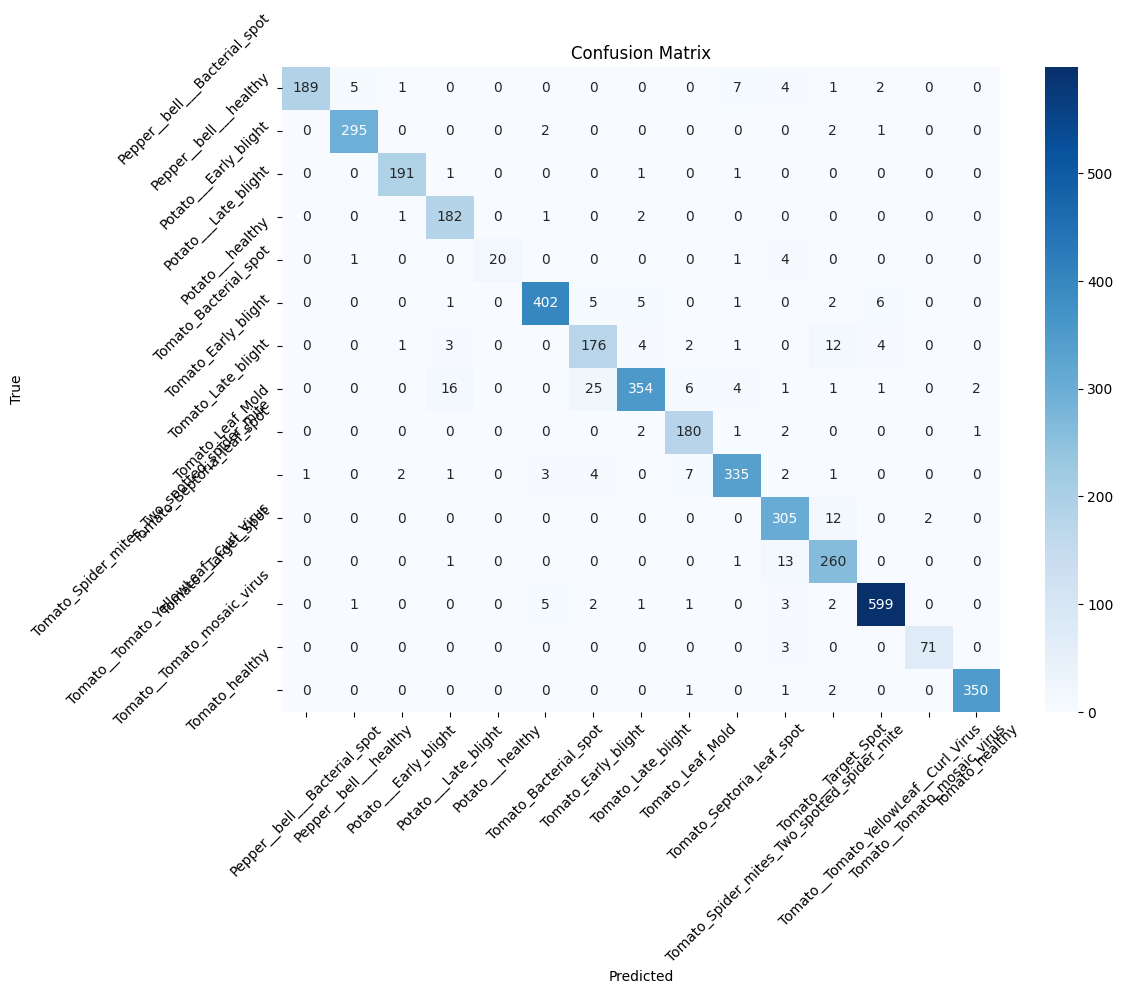

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


In [24]:
num_epochs = 1
print_interval = 100

model, train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs, print_interval)


Epoch [1/1], Batch [100/1032], Train Loss: 0.2525, Train Accuracy: 91.62%
Epoch [1/1], Batch [200/1032], Train Loss: 0.2422, Train Accuracy: 92.09%
Epoch [1/1], Batch [300/1032], Train Loss: 0.2408, Train Accuracy: 92.08%
Epoch [1/1], Batch [400/1032], Train Loss: 0.2407, Train Accuracy: 92.05%
Epoch [1/1], Batch [500/1032], Train Loss: 0.2433, Train Accuracy: 91.95%
Epoch [1/1], Batch [600/1032], Train Loss: 0.2452, Train Accuracy: 91.77%
Epoch [1/1], Batch [700/1032], Train Loss: 0.2494, Train Accuracy: 91.59%
Epoch [1/1], Batch [800/1032], Train Loss: 0.2532, Train Accuracy: 91.59%
Epoch [1/1], Batch [900/1032], Train Loss: 0.2547, Train Accuracy: 91.55%
Epoch [1/1], Batch [1000/1032], Train Loss: 0.2562, Train Accuracy: 91.48%
Epoch [1/1], Batch [1032/1032], Train Loss: 0.2547, Train Accuracy: 91.51%
Epoch [1/1] | Train Loss: 0.2547 | Train Accuracy: 91.51% | Val Loss: 0.1497 | Val Accuracy: 94.94% | Time: 338.13s


In [25]:

torch.save(model.state_dict(), "simple_cnn1.pth")


In [26]:
model = SimpleCNN(num_classes=15)
model.load_state_dict(torch.load("simple_cnn1.pth"))
model.to(device)
model.eval()

from sklearn.metrics import classification_report, accuracy_score

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=classes))

acc = accuracy_score(all_labels, all_preds)
print(f"Overall Accuracy: {acc:.4f}")



Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.98      0.94      0.96       209
                     Pepper__bell___healthy       0.98      0.98      0.98       300
                      Potato___Early_blight       0.97      0.99      0.98       194
                       Potato___Late_blight       0.89      0.98      0.93       186
                           Potato___healthy       1.00      0.81      0.89        26
                      Tomato_Bacterial_spot       0.98      0.96      0.97       422
                        Tomato_Early_blight       0.84      0.86      0.85       203
                         Tomato_Late_blight       0.97      0.84      0.90       410
                           Tomato_Leaf_Mold       0.91      0.98      0.94       186
                  Tomato_Septoria_leaf_spot       0.94      0.95      0.95       356
Tomato_Spider_mites_Two_spotted_spider_m

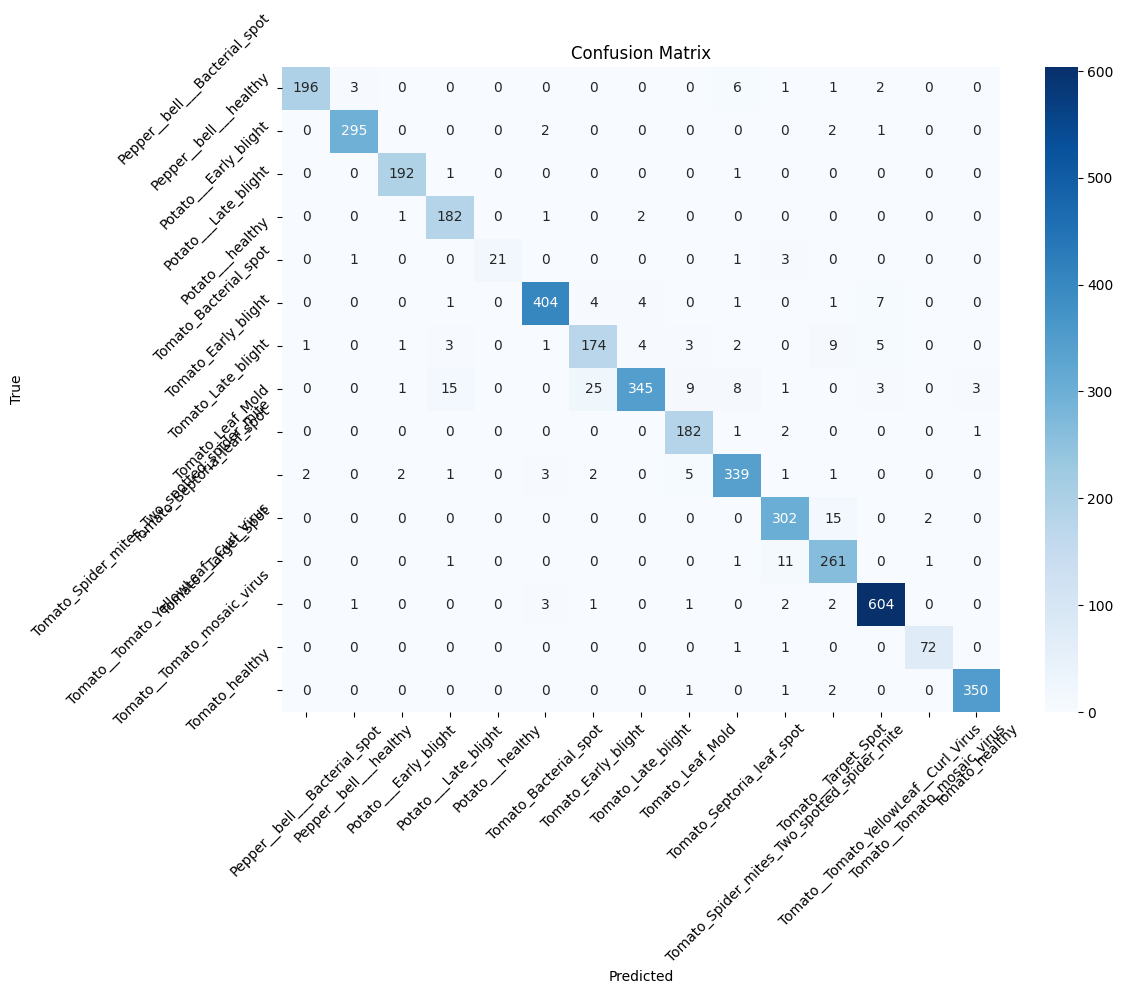

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
